In [3]:
# General purpose imports to handle paths, files etc
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json


# Useful functions to define and import datasets from open neuro
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt



def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')

In [4]:
#loading the data
dataset_id = 'ds000102'
subject = '01' 

# create dataset folder
sample_path = "dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)


func_path = op.join(bids_root, 'sub-01', 'func')
anat_path = op.join(bids_root, 'sub-01', 'anat')
mkdir_no_exist(op.join(bids_root, 'sub-01'))
mkdir_no_exist(func_path)
mkdir_no_exist(anat_path)

In [5]:
direct_file_download_open_neuro(file_list=['sub-01_task-flanker_run-1_bold.nii.gz', 
                                           'sub-01_task-flanker_run-2_bold.nii.gz',
                                           'sub-01_T1w.nii.gz'], 
                                file_types=['func', 'func', 'anat'], 
                                dataset_id=dataset_id, 
                                dataset_version='00001', 
                                save_dirs=[func_path,
                                           func_path,
                                           anat_path])

mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-01'))
mkdir_no_exist(op.join(preproc_root, 'sub-01', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-01', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-01', 'fmap'))

Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-01:func:sub-01_task-flanker_run-1_bold.nii.gz


sub-01:func:sub-01_task-flanker_run-1_bold.nii.gz: 28.1MB [00:02, 10.6MB/s]                            


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-01:func:sub-01_task-flanker_run-2_bold.nii.gz


sub-01:func:sub-01_task-flanker_run-2_bold.nii.gz: 28.1MB [00:15, 1.78MB/s]                            


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-01:anat:sub-01_T1w.nii.gz


sub-01:anat:sub-01_T1w.nii.gz: 10.6MB [00:02, 5.25MB/s]                            

Ok


# 1- Visualizing data

### Anatomical data

Let's first begin to visualize the **anatomical scan** of our chosen subject: sub-01 !

In [7]:
reset_overlays()
load(op.join(bids_root, 'sub-01', 'anat', 'sub-01_T1w.nii.gz'))

Image(sub-01_T1w, /home/ffriedli/Desktop/MyFiles/NSSP/dataset/ds000102/sub-01/anat/sub-01_T1w.nii.gz)

<img src="imgs/vis_anat.png">

In [8]:
import nibabel as nib
%matplotlib inline

def load_data(path:str) -> np.ndarray :
    img = nib.load(path)
    data = img.get_fdata()
    return data

def plot_anat(data : np.ndarray, title, slice : int = None) -> None : 
    
    sub_title = ["sagittal view", "coronal view", "axial view" ]


    fig, ax = plt.subplots(1,3, figsize=(9, 3))
    fig.tight_layout()
    for i, ax in enumerate(ax):
        if slice == None :
            s = int(data.shape[i]/2)
        else :
            s = slice
        ax.imshow(np.rot90(data.take(s,axis=i)), cmap="gray", aspect="auto")
        ax.set_title(sub_title[i])
    fig.suptitle(title, x=0.5, y=1.2)
    plt.show()

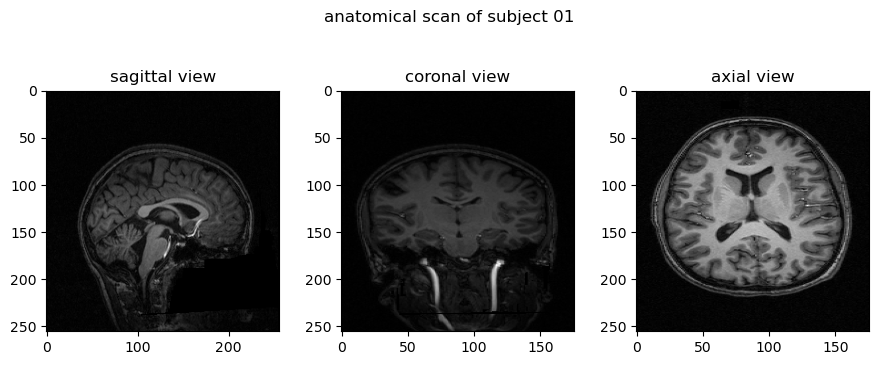

In [10]:
anat_sub_01 = load_data(op.join(bids_root, 'sub-01', 'anat', 'sub-01_T1w.nii.gz'))
plot_anat(anat_sub_01, "anatomical scan of subject 01")

### Functional data

And let's now visualize the **functional scan**.

In [11]:
reset_overlays()
load(op.join(bids_root, 'sub-01', 'func', 'sub-01_task-flanker_run-1_bold.nii.gz'))

Image(sub-01_task-flanker_run-1_bold, /home/opetit/Desktop/MyFiles/NSSP/dataset/ds000102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz)

<center><img src="imgs/vis_func_run1.gif"/>
    <p style="text-align:center;"><i>Functional data for sub01 for the first run of the Flanker task</i></p></center>


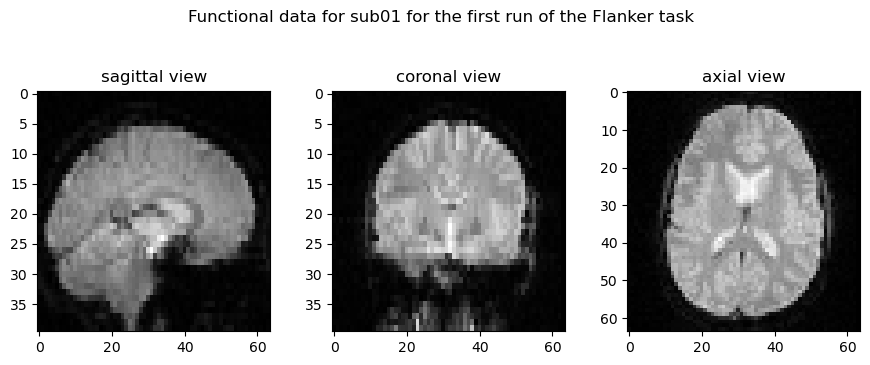

In [9]:
func_data_sub1_run1 = load_data(op.join(bids_root, 'sub-01', 'func', 'sub-01_task-flanker_run-1_bold.nii.gz'))
plot_anat(func_data_sub1_run1[:,:,:,73], #select a time, a specific volume to plot,
          title = "Functional data for sub01 for the first run of the Flanker task")

In [10]:
reset_overlays()
load(op.join(bids_root, 'sub-01', 'func', 'sub-01_task-flanker_run-2_bold.nii.gz'))

Image(sub-01_task-flanker_run-2_bold, /home/opetit/Desktop/MyFiles/NSSP/dataset/ds000102/sub-01/func/sub-01_task-flanker_run-2_bold.nii.gz)

<center><img src="imgs/vis_func_run2.gif"/>
    <p style="text-align:center;"><i>Functional data for sub01 for the second run of the Flanker task</i></p></center>


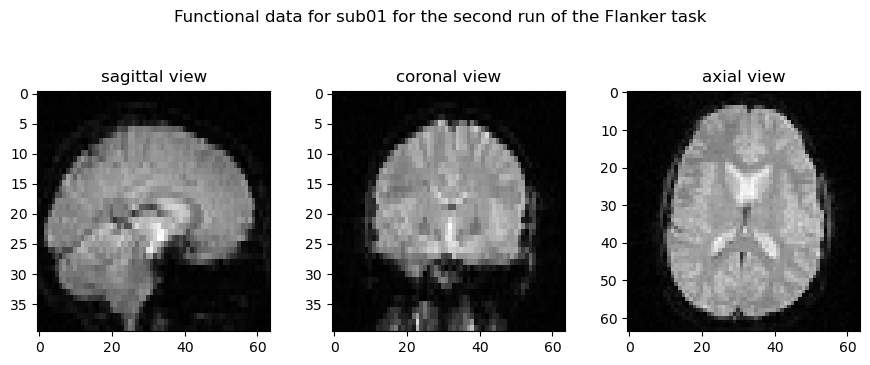

In [11]:
func_data_sub1_run2 = load_data(op.join(bids_root, 'sub-01', 'func', 'sub-01_task-flanker_run-2_bold.nii.gz'))
plot_anat(func_data_sub1_run2[:,:,:,73],
          title = "Functional data for sub01 for the second run of the Flanker task")

# 2- Brain extraction
We will perform brain extraction on the anatomical volume, so basically remove the skull to end up only with the brain. To do this we will use the FSL program BET (*brain extraction tool*) which will generate a mask for the brain region of interest. 

The resulting mask will be stored in the *derivatives* folder to make sure that the raw source data is kept untouched.

In [5]:
def brain_extraction(subject : str, name_file, frac_dens : float = 0.5) -> tuple[str,str,str]:
    
    sub_num = "sub-"+ subject
    nb = int(frac_dens*10)
    
    anatomical_path = op.join(bids_root, sub_num, 'anat', name_file + '.nii.gz')
    betted_brain_path = op.join(preproc_root, sub_num, 'anat', name_file +'0%i.nii.gz' % nb)
    resulting_mask_path = op.join(preproc_root, sub_num, 'anat', name_file + '0%i_mask.nii.gz' % nb)
    
    bet(anatomical_path, betted_brain_path, mask=resulting_mask_path, fracintensity = frac_dens)
    
    return anatomical_path, betted_brain_path, resulting_mask_path
    

In [6]:
anatomical_path, betted_brain_path, resulting_mask_05_path = brain_extraction("01", "sub-01_T1w")

In [7]:
# visualization throught FSLeyes
reset_overlays()
load(anatomical_path)
load(resulting_mask_05_path)

Image(sub-01_T1w05_mask, /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/anat/sub-01_T1w05_mask.nii.gz)

<center><img src="imgs/bet_mask_default.png"/>
    <p style="text-align:center;"><i>Brain extraction on the anatomical image using a default fractional intensity threshold of 0.5</i></p></center>

In [15]:
mask_05 = load_data(resulting_mask_05_path)
img_05 = load_data(anatomical_path)
img_05[mask_05==1] += np.max(img_05)/2 #Choose the higher voxel value which correspond to white then add half of this value to make the mask "transparant"

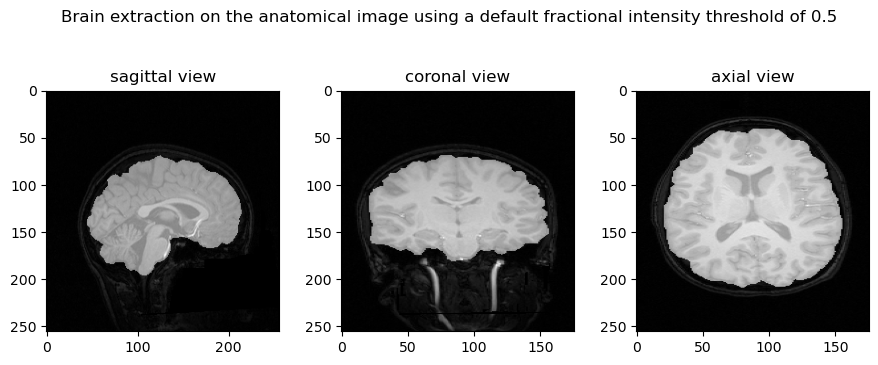

In [16]:
plot_anat(img_05,
         title = "Brain extraction on the anatomical image using a default fractional intensity threshold of 0.5" )

The results above were obtained by using bet with a default fractional intensity threshold of 0.5. But let's explore the results with different fractional intensity thresholds ! For comparison we will focus on voxel (87,126,116)

> **_Fractional intensity threshold:_** ranging from 0 to 1, this threshold determines the amount of brain extracted by the mask. If we think that too much brain has been removed when using the default threshold, we should set this threshold to a smaller number to obtain a larger brain outline.


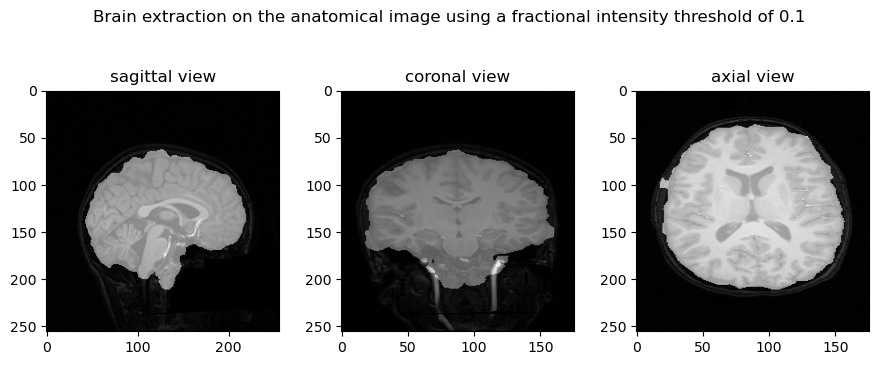

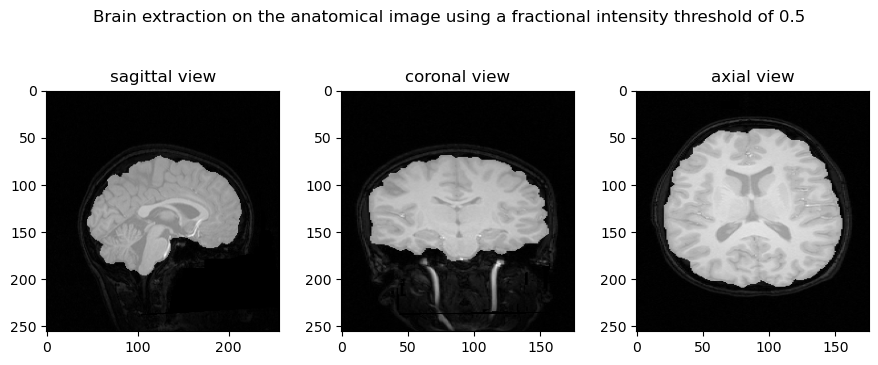

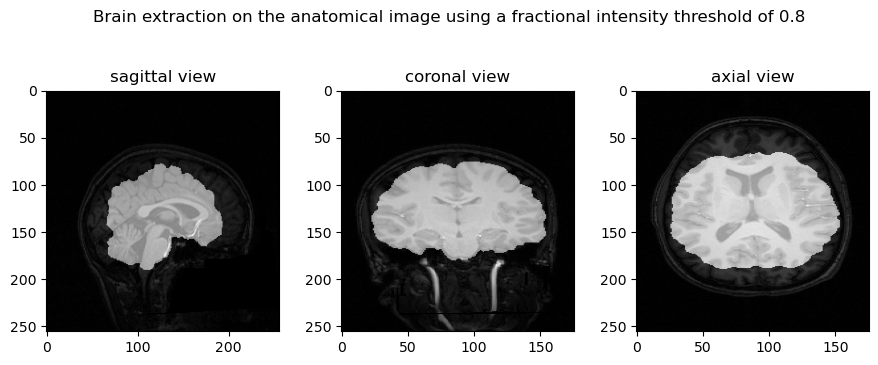

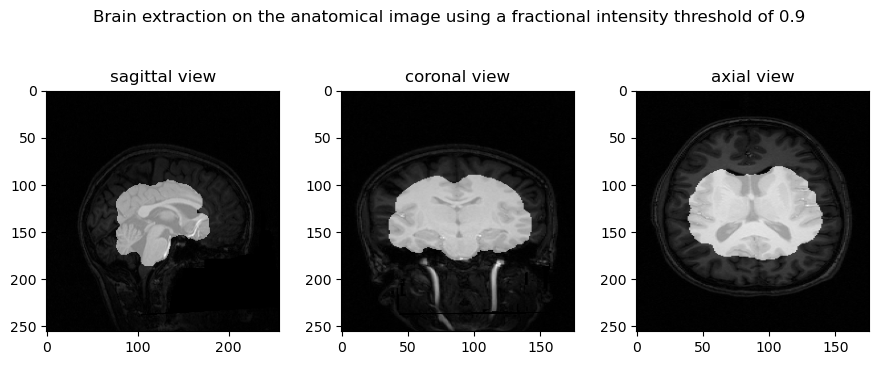

In [17]:
for i in [0.1,0.5,0.8,0.9] :
    anatomical_path, betted_brain_path, resulting_mask_path = brain_extraction("01", "sub-01_T1w", i)
    img = load_data(anatomical_path)
    mask= load_data(resulting_mask_path)
    img[mask==1]+= np.max(img)/2
    plot_anat(img, title = "Brain extraction on the anatomical image using a fractional intensity threshold of {}".format(i))

In [8]:
# visualization throught FSLeyes: FIT=0.1
reset_overlays()
load(anatomical_path)
load(op.join(preproc_root, 'sub-01', 'anat', "sub-01_T1w" + '01_mask.nii.gz'))

Image(sub-01_T1w01_mask, /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/anat/sub-01_T1w01_mask.nii.gz)

<center><img src="imgs/bet_mask_01.png"/>
    <p style="text-align:center;"><i>Brain extraction on the anatomical image using a fractional intensity threshold of 0.1</i></p></center>

In [9]:
# visualization throught FSLeyes: FIT=0.9
reset_overlays()
load(anatomical_path)
load(op.join(preproc_root, 'sub-01', 'anat', "sub-01_T1w" + '09_mask.nii.gz'))

Image(sub-01_T1w09_mask, /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/anat/sub-01_T1w09_mask.nii.gz)

<center><img src="imgs/bet_mask_09.png"/>
    <p style="text-align:center;"><i>Brain extraction on the anatomical image using a fractional intensity threshold of 0.9</i></p></center>

We see that by setting a lower fractional intensity threshold, a larger region of the brain is extracted by bet.

# 3- Motion correction

### 1) Motion parameters

Let's compute the motion parameters for the first run and second run of subject 01

In [10]:
#run 1
path_original_data1 = os.path.join(bids_root, 'sub-01', 'func', 'sub-01_task-flanker_run-1_bold.nii.gz')
path_moco_data1 = os.path.join(preproc_root, 'sub-01', 'func', 'sub-01_task-flanker_run-1_bold_moco')
mcflirt(infile=path_original_data1,o=path_moco_data1, plots=True, report=True, dof=6, mats=True)

#run 2
path_original_data2 = os.path.join(bids_root, 'sub-01', 'func', 'sub-01_task-flanker_run-2_bold.nii.gz')
path_moco_data2 = os.path.join(preproc_root, 'sub-01', 'func', 'sub-01_task-flanker_run-2_bold_moco')
mcflirt(infile=path_original_data2,o=path_moco_data2, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [73] to 8 mm pixels
Registering volumes ... [74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][72][71][70][69][68][67][66][65][64][63][62][61][60][59][58][57][56][55][54][53][52][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm s

refnum = 73
Original_refvol = -1


Registering volumes ... [74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][72][71][70][69][68][67][66][65][64][63][62][61][60][59][58][57][56][55][54][53][52][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 
Processed data will be saved as /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-2_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [73] to 8 mm

refnum = 73
Original_refvol = -1


Registering volumes ... [74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][72][71][70][69][68][67][66][65][64][63][62][61][60][59][58][57][56][55][54][53][52][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


{}

In [21]:
# Visualize using FSL (run1)
reset_overlays()
load(path_original_data1)
load(path_moco_data1)

Image(sub-01_task-flanker_run-1_bold_moco, /home/opetit/Desktop/MyFiles/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-1_bold_moco.nii.gz)

<center><img src="imgs/func_run1.png"/>
    <p style="text-align:center;"><i>FSL view of the original data of run 1</i></p></center>

In [19]:
# Visualize using FSL (run2)
reset_overlays()
load(path_original_data2)
load(path_moco_data2)

Image(sub-01_task-flanker_run-2_bold_moco, /home/challier/Desktop/MyFiles/My_Documents/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-2_bold_moco.nii.gz)

<center><img src="imgs/func_run2.png"/>
    <p style="text-align:center;"><i>FSL view of the original data of run 2</i></p></center>

Lets look at the motion parameters for both runs of subject 1 :

In [14]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

In [15]:
# Motion parameters of run1
mot_params1 = load_mot_params_fsl_6_dof(path_moco_data1 + ".par")
mot_params1

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.002731,-0.002763,-0.002376,-0.154286,0.011919,0.032888
1,-0.002989,-0.002625,-0.002376,-0.158850,0.027467,0.087529
2,-0.002903,-0.002552,-0.002242,-0.166514,0.026961,0.099782
3,-0.002523,-0.002763,-0.002376,-0.166644,0.014205,0.087150
4,-0.002404,-0.002709,-0.002376,-0.168801,-0.007525,0.062447
...,...,...,...,...,...,...
141,0.001576,0.000096,-0.001420,-0.047908,0.071218,-0.203898
142,0.001383,-0.000248,-0.001420,-0.041588,0.098485,-0.208978
143,0.001342,-0.000108,-0.001420,-0.036894,0.079022,-0.195061
144,0.001722,-0.000180,-0.001420,-0.036915,0.094487,-0.209467


In [16]:
# Motion parameters of run2
mot_params2 = load_mot_params_fsl_6_dof(path_moco_data2 + ".par")
mot_params2

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.003468,0.000422,-0.000552,-0.144510,-0.010928,-0.101182
1,-0.003359,-0.000256,-0.000283,-0.132041,0.005123,-0.028714
2,-0.003456,0.000020,-0.000192,-0.126529,0.005155,-0.009243
3,-0.003459,-0.000256,-0.000192,-0.120500,0.005152,0.007173
4,-0.004106,0.000008,-0.000192,-0.100605,0.005305,0.121364
...,...,...,...,...,...,...
141,0.001228,-0.000737,0.002242,0.146223,0.071707,0.065448
142,0.001963,-0.000463,0.002607,0.165264,0.046997,0.060333
143,0.002454,-0.000667,0.002254,0.179715,0.074948,0.042585
144,0.002928,-0.000371,0.002492,0.182762,0.051246,0.006908


It is nicer to visualize the motion parameters of the 2 runs in forms of plot!

In [17]:
import seaborn as sns

def MOT_plot (mot_params, run) :
    fig, axes = plt.subplots(1, 2, figsize=(16,4))
    fig.suptitle(f'MOT parameters comparison of run {run}')

    sns.lineplot(mot_params[["Rotation x", "Rotation y", "Rotation z"]], ax=axes[0])
    sns.lineplot(mot_params[["Translation x", "Translation y", "Translation z"]], ax=axes[1])

    axes[0].set_xlabel('Volume')
    axes[1].set_xlabel('Volume')
    axes[0].set_ylabel('mot params values')
    axes[0].legend(loc='lower right')
    axes[1].legend(loc='lower right')

    plt.show()

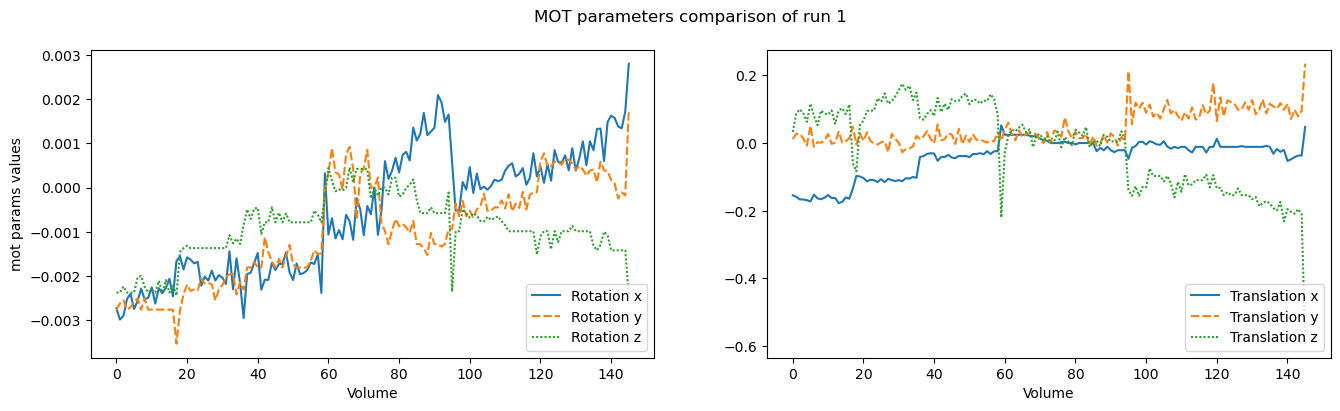

In [32]:
MOT_plot (mot_params1, 1)

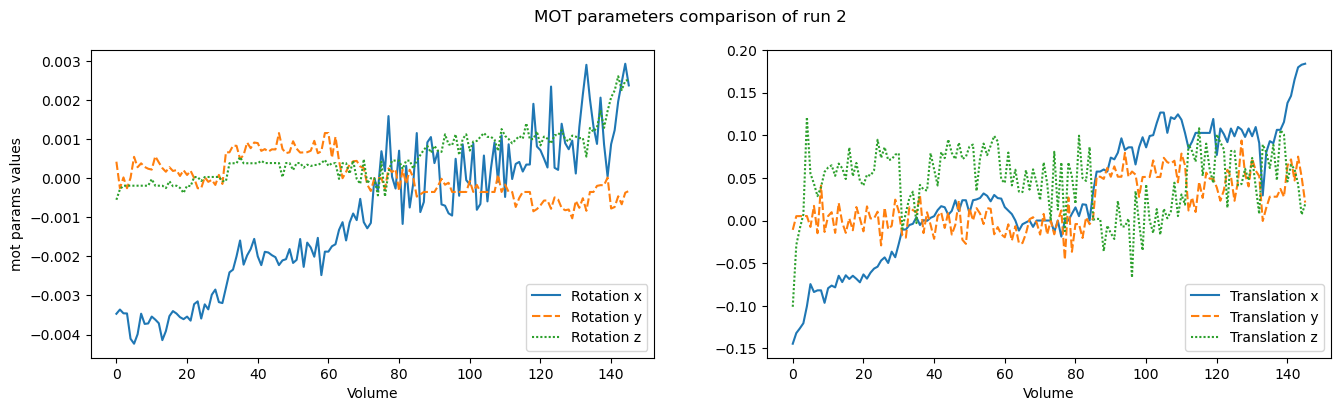

In [33]:
MOT_plot (mot_params2, 2)

The graphs above represent the 6 motion parameters (3 rotations and 3 translations) for each volume of the functional fMRI data.

We see that each volume moved differently and thus each volumes had to be transformed in a slightly different way during motion correction, resulting in slighty different motion parameters for each volume.

We see that in run2, there is almost no change across volumes for the rotation parameters around y and z and also for the translation parameters along y and z. So, the parameter which changes the most across volumes is the rotation and translation in x. This means that sub-01 moved its head laterally around the x-axis and also rotated it a bit around that same axis. 

In run1, all rotation parameters follow the same trend, and also all translation parameters follow the same trend. This means that in this run sub-01 moved its head in all direction whereas in run2 the movement was more in direction x.

So, in run2 the subject's head was steadier than in run1.

### 2) Framewise displacement

In order to more precisely analyse the motions parameters, the frame displacement can be computed.

In [19]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]

    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

In [20]:
fd1 = compute_FD_power(mot_params1).to_numpy()
fd2 = compute_FD_power(mot_params2).to_numpy()

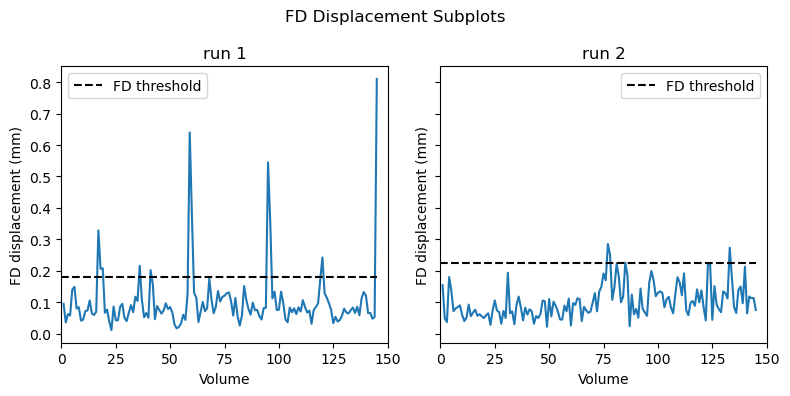

In [69]:
fd_data_list = [fd1,fd2]
num_subplots = len(fd_data_list)

fig, axes = plt.subplots(1,num_subplots, figsize=(4 * num_subplots, 4), sharey=True)
fig.suptitle('FD Displacement Subplots')

for i, fd_data in enumerate(fd_data_list):
    threshold = np.quantile(fd_data,0.75) + 1.5*(np.quantile(fd_data,0.75) - np.quantile(fd_data,0.25))
    ax = axes[i]
    ax.plot(list(range(1, len(fd_data) + 1)), fd_data)
    ax.set_xlabel('Volume')
    ax.set_xlim([0, 150])
    ax.set_ylabel('FD displacement (mm)')
    ax.hlines(threshold, 0, len(fd_data), colors='black', linestyles='dashed', label='FD threshold')
    ax.set_title("run %i" %(i+1))
    ax.legend()

plt.tight_layout()
plt.show()

In [68]:
crossed = [np.where(fd > threshold)[0] + 1 for fd in fd_data_list]

print(f"Threshold = {threshold}", "\n")

print("Run 1:", "\n", f"Number of outlier volumes: {len(crossed[0])}", "\n", f"Volumes for which the FD is above threshold: {crossed[0]}", "\n")
print("Run 2:", "\n", f"Number of outlier volumes: {len(crossed[1])}", "\n",f"Volumes for which the FD is above threshold: {crossed[1]}")

Threshold = 0.225636985 

Run 1: 
 Number of outlier volumes: 7 
 Volumes for which the FD is above threshold: [ 17  59  60  95  96 120 145] 

Run 2: 
 Number of outlier volumes: 3 
 Volumes for which the FD is above threshold: [ 77  78 133]


The first and second graph above represent the framewise displacement (FD) for each of the functional volumes for run1 and run2 of sub-01 respectively. The dashed line represents the threshold above which a FD is considered as being too high. 

In run1, the FD of 7 volumes crossed the threshold, meaning that they had to be displaced a lot by motion correction in order to be realigned to the reference volume. This is consistant with what was interpreted in the previous section where we saw that in run1 the subject moved his/her head along all possible directions (x, y, z). 

In run2, only 3 FDs cross the threshold. This is also consistant with the rotation and translation parameter graphs of the previous section were we saw that for run2 the subject mainly moved her/his head along x. 

### 3) Motion correction

In [24]:
output_path_volume = os.path.join(preproc_root, 'sub-01', 'func', 'sub-01_task-flanker_run-1_bold_bbr')
fslroi(path_moco_data1,output_path_volume, str(60), str(1))

{}

In [40]:
reset_overlays()
load(output_path_volume)

Image(sub-01_task-flanker_run-1_bold_bbr, /home/ffriedli/Desktop/MyFiles/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-1_bold_bbr.nii.gz)

<center><img src="imgs/Volume_of_choice.png"/>
    <p style="text-align:center;"><i>Volume chosen for visualization</i></p></center>

### 4) Differences between original and motion-corrected data

Here, we aim to analyze the efficiency of our motion correction. To do this, let's select a set of voxels and observe the differences between the original data and the motion-corrected data.

In [25]:
reset_overlays()
load(path_original_data1) #load the original data
load(path_moco_data1) #load the motion-corrected data

Image(sub-01_task-flanker_run-1_bold_moco, /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-1_bold_moco.nii.gz)

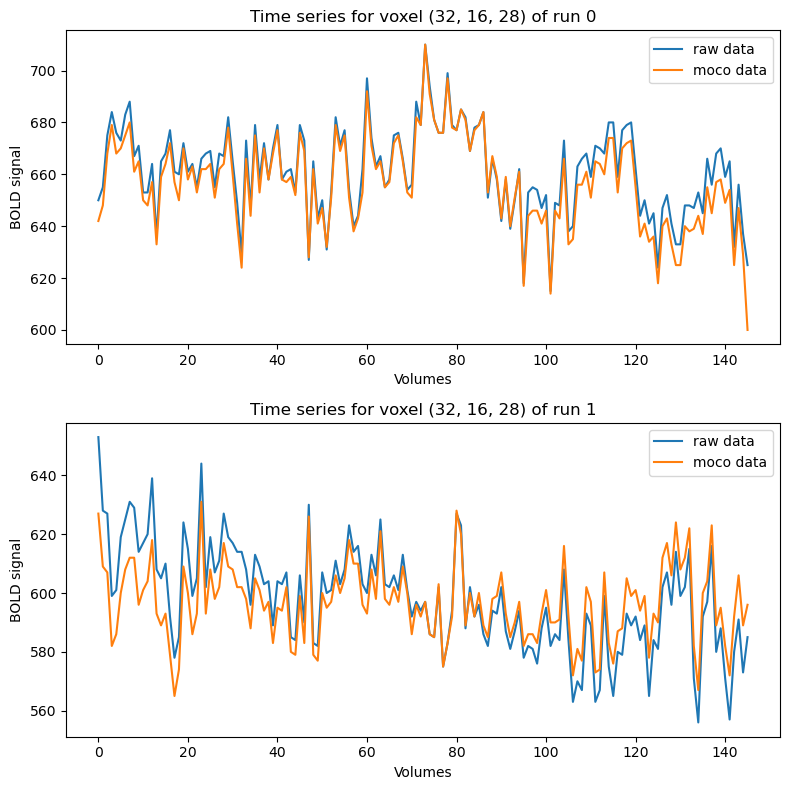

In [26]:
import nibabel as nib

# chosen voxel
x, y, z = 32, 16, 28

path_original_data = [path_original_data1, path_original_data2]
path_moco_data = [path_moco_data1, path_moco_data2]
num_subplots = len(fd_data_list)

fig, axes = plt.subplots(num_subplots, 1, figsize=(8, 4 * num_subplots))

for i, [path_original_data, path_moco_data] in enumerate(zip(path_original_data, path_moco_data)):

    ax = axes[i]
    # load raw functional volumes and extract time series
    data_raw = load_data(path_original_data)
    voxel_time_seires_raw = data_raw[x, y, z, :]

    # load motion corrected functional volumes and extract time series
    data_moco = load_data(path_moco_data+ ".nii.gz")
    voxel_time_seires_moco = data_moco[x, y, z, :]

    ax.plot(voxel_time_seires_raw, label="raw data")
    ax.plot(voxel_time_seires_moco, label="moco data")
    ax.set_title("Time series for voxel (32, 16, 28) of run {}".format(i))
    ax.set_xlabel("Volumes")
    ax.set_ylabel("BOLD signal")
    ax.legend()

plt.tight_layout()
plt.show()

The image displays the time series for a specific voxel for the original data and the motion corrected data. The two time series are different. Indeed, after motion correction, the targeted voxel doesn't point to the same brain position anymore and thus the recorded BOLD signal is different from the original data due to displacements induced by motion correction.

### 5) Compare motion correction results between differents subjects

First let's create a reference image for motion correction by generating a mean functional image.


In [27]:
img_moco = nib.load(path_moco_data + ".nii.gz")
data_moco = img_moco.get_fdata()

data_moco_mean = np.mean(data_moco, axis=-1)
data_moco_mean_nib = nib.Nifti1Image(data_moco_mean, img_moco.affine, img_moco.header)
data_moco_mean_path = os.path.join(preproc_root, "sub-01", 'func', 'mean_func.nii.gz')
nib.save(data_moco_mean_nib, data_moco_mean_path)

print(np.shape(data_moco_mean))

(64, 64, 40)


In [28]:
#motion correction
path_moco_data_mean = os.path.join(preproc_root, 'sub-01', 'func', 'sub-01' + '_task-flanker_run-1_bold_mean_moco')
mcflirt(infile=path_original_data1,o=path_moco_data_mean, plots=True, report=True, dof=6, mats=True, refvol="mean")

Processed data will be saved as /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-1_bold_mean_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [0] to 8 mm pixels
Registering volumes ... [1][2][3][4][5][6][7][8][9][10][11][12][13][14][15][16][17][18][19][20][21][22][23][24][25][26][27][28][29][30][31][32][33][34][35][36][37][38][39][40][41][42][43][44][45][46][47][48][49][50][51][52][53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145]
second iteration - drop to 

refnum = 0
Original_refvol = 0


Registering volumes ... [1][2][3][4][5][6][7][8][9][10][11][12][13][14][15][16][17][18][19][20][21][22][23][24][25][26][27][28][29][30][31][32][33][34][35][36][37][38][39][40][41][42][43][44][45][46][47][48][49][50][51][52][53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145]
Saving motion corrected time series... 


{}

In [29]:
reset_overlays()
load(path_original_data) #load the original data
load(path_moco_data) #load the motion-corrected data

Image(sub-01_task-flanker_run-2_bold_moco, /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-2_bold_moco.nii.gz)

<center><img src="imgs/moco_mean_vid.gif"/>
    <p style="text-align:center;"><i>Motion corrected function data (movie mode)</i></p>
    </center>

Then let's create a pipeline to automatically load patient data and obtain the motion correct data, the motion parameters and the FD.

In [31]:
def set_data(dataset_id, subject) :
    
    #set path
    sub_number = 'sub-'+ subject
    sample_path = "dataset"
    mkdir_no_exist(sample_path)
    bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
    deriv_root = op.join(bids_root, 'derivatives')
    preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
    mkdir_no_exist(bids_root)

    func_path = op.join(bids_root, sub_number, 'func')
    anat_path = op.join(bids_root, sub_number, 'anat')
    mkdir_no_exist(op.join(bids_root, sub_number))
    mkdir_no_exist(func_path)
    mkdir_no_exist(preproc_root)
    mkdir_no_exist(anat_path)
    
    #load data
    direct_file_download_open_neuro(file_list=[sub_number + '_task-flanker_run-1_bold.nii.gz', 
                                           sub_number + '_task-flanker_run-2_bold.nii.gz',
                                           sub_number + '_T1w.nii.gz'], 
                                file_types=['func', 'func', 'anat'], 
                                dataset_id=dataset_id, 
                                dataset_version='00001', 
                                save_dirs=[func_path,
                                           func_path,
                                           anat_path])

    mkdir_no_exist(op.join(bids_root, 'derivatives'))
    mkdir_no_exist(op.join(preproc_root, sub_number))
    mkdir_no_exist(op.join(preproc_root, sub_number, 'anat'))
    mkdir_no_exist(op.join(preproc_root, sub_number, 'func'))
    mkdir_no_exist(op.join(preproc_root, sub_number, 'fmap'))

    return bids_root, preproc_root

def motion_correction(dataset_id, subject):
    
    bids_root, preproc_root = set_data(dataset_id, subject)
    
    sub_number = 'sub-'+ subject
    anatomical_path, betted_brain_path, resulting_mask_05_path = brain_extraction(subject, "sub-"+ subject +'_T1w')
    
    #motion correction
    path_original_data = os.path.join(bids_root, sub_number, 'func', sub_number + '_task-flanker_run-1_bold.nii.gz')
    path_moco_data = os.path.join(preproc_root, sub_number, 'func', sub_number + '_task-flanker_run-1_bold_moco')
    #mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True, refvol="mean")
    
    '''
    data_moco = load_data(path_moco_data + ".nii.gz")
    data_moco_mean = np.mean(data_moco, axis=-1)
    data_moco_mean_nib = nib.Nifti1Image(data_moco_mean, img_moco.affine, img_moco.header)
    data_moco_mean_path = os.path.join(preproc_root, sub_number, 'func', 'mean_func.nii.gz')
    nib.save(data_moco_mean_nib, data_moco_mean_path)
    # use -meanvol ???
    '''
    
    #mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True, refvol=data_moco_mean_path)
    mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True, meanvol=True)

    mot_params = load_mot_params_fsl_6_dof(path_moco_data +'.par')
    
    return path_original_data, path_moco_data, mot_params, compute_FD_power(mot_params).to_numpy()

    

In [32]:
list_patient = ['01','02','03']
dataset_id = 'ds000102'

#correct the motion for 3 subjects
results = [motion_correction(dataset_id, patient ) for patient in list_patient]

Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-01:func:sub-01_task-flanker_run-1_bold.nii.gz


sub-01:func:sub-01_task-flanker_run-1_bold.nii.gz: 28.1MB [00:03, 8.88MB/s]                              


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-01:func:sub-01_task-flanker_run-2_bold.nii.gz


sub-01:func:sub-01_task-flanker_run-2_bold.nii.gz: 28.1MB [00:02, 9.45MB/s]                              


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-01:anat:sub-01_T1w.nii.gz


sub-01:anat:sub-01_T1w.nii.gz: 10.6MB [00:02, 4.95MB/s]                            


Ok


Processed data will be saved as /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [73] to 8 mm pixels
Registering volumes ... [74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][72][71][70][69][68][67][66][65][64][63][62][61][60][59][58][57][56][55][54][53][52][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm s

Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-02:func:sub-02_task-flanker_run-1_bold.nii.gz


sub-02:func:sub-02_task-flanker_run-1_bold.nii.gz: 29.2MB [00:03, 9.33MB/s]                              


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-02:func:sub-02_task-flanker_run-2_bold.nii.gz


sub-02:func:sub-02_task-flanker_run-2_bold.nii.gz: 29.2MB [00:14, 2.04MB/s]                              


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-02:anat:sub-02_T1w.nii.gz


sub-02:anat:sub-02_T1w.nii.gz: 10.7MB [00:02, 4.79MB/s]                            


Ok


Processed data will be saved as /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-02/func/sub-02_task-flanker_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [73] to 8 mm pixels
Registering volumes ... [74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][72][71][70][69][68][67][66][65][64][63][62][61][60][59][58][57][56][55][54][53][52][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm s

Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-03:func:sub-03_task-flanker_run-1_bold.nii.gz


sub-03:func:sub-03_task-flanker_run-1_bold.nii.gz: 28.8MB [00:02, 11.4MB/s]                            


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-03:func:sub-03_task-flanker_run-2_bold.nii.gz


sub-03:func:sub-03_task-flanker_run-2_bold.nii.gz: 28.8MB [00:03, 9.09MB/s]                            


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-03:anat:sub-03_T1w.nii.gz


sub-03:anat:sub-03_T1w.nii.gz: 10.7MB [00:01, 5.84MB/s]                            


Ok


Processed data will be saved as /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-03/func/sub-03_task-flanker_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [73] to 8 mm pixels
Registering volumes ... [74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][72][71][70][69][68][67][66][65][64][63][62][61][60][59][58][57][56][55][54][53][52][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm s

In [37]:
params_list = [results[0][2],results[1][2],results[2][2]]

In [71]:
def plot_mean_motion(mot_paths : list):
    num = len(mot_paths)
    
    rotx = []
    roty = []
    rotz = []
    transx = []
    transy = []
    transz = []
    
    for subject in range(num):
        rotx.append(np.mean(mot_paths[subject]['Rotation x']))
        roty.append(np.mean(mot_paths[subject]['Rotation y']))
        rotz.append(np.mean(mot_paths[subject]['Rotation z']))
        
        transx.append(np.mean(mot_paths[subject]['Translation x']))
        transy.append(np.mean(mot_paths[subject]['Translation y']))
        transz.append(np.mean(mot_paths[subject]['Translation z']))
        
    species = ("Rotation x", "Rotation y", "Rotation z")
    rotation_means = {
        'Subject 1': (np.abs(rotx[0]), np.abs(roty[0]), np.abs(rotz[0])),
        'Subject 2': (np.abs(rotx[1]), np.abs(roty[1]), np.abs(rotz[1])),
        'Subject 3': (np.abs(rotx[2]), np.abs(roty[2]), np.abs(rotz[2])),
    }

    x = np.arange(len(species))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in rotation_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Length (mm)')
    ax.set_title('Rotation parameters')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 0.004)
   

    plt.show()
    
    species = ("Translation x", "Translation y", "Translation z")
    translation_means = {
        'Subject 1': (np.abs(transx[0]), np.abs(transy[0]), np.abs(transz[0])),
        'Subject 2': (np.abs(transx[1]), np.abs(transy[1]), np.abs(transz[1])),
        'Subject 3': (np.abs(transx[2]), np.abs(transy[2]), np.abs(transz[2])),

    }

    x = np.arange(len(species))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in translation_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Length (mm)')
    ax.set_title('Translation parameters')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 0.07)

    

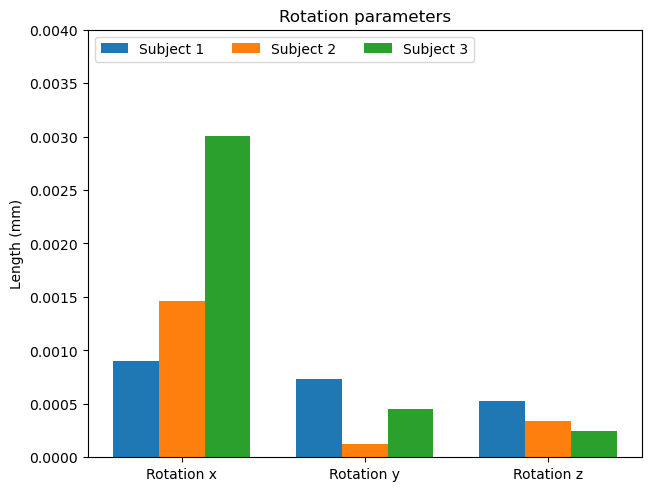

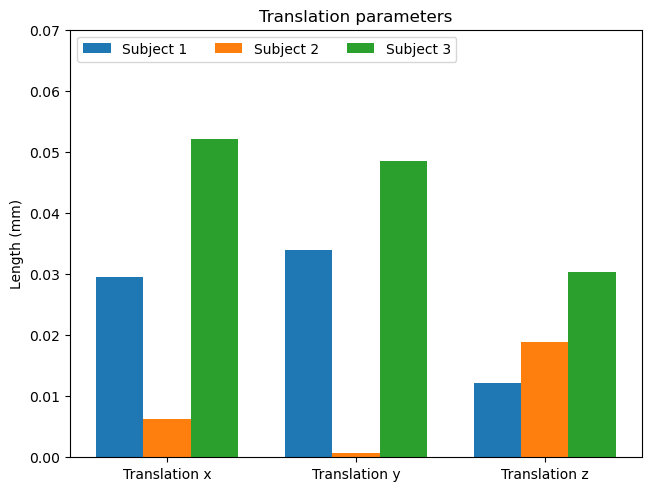

In [72]:
plot_mean_motion(params_list)

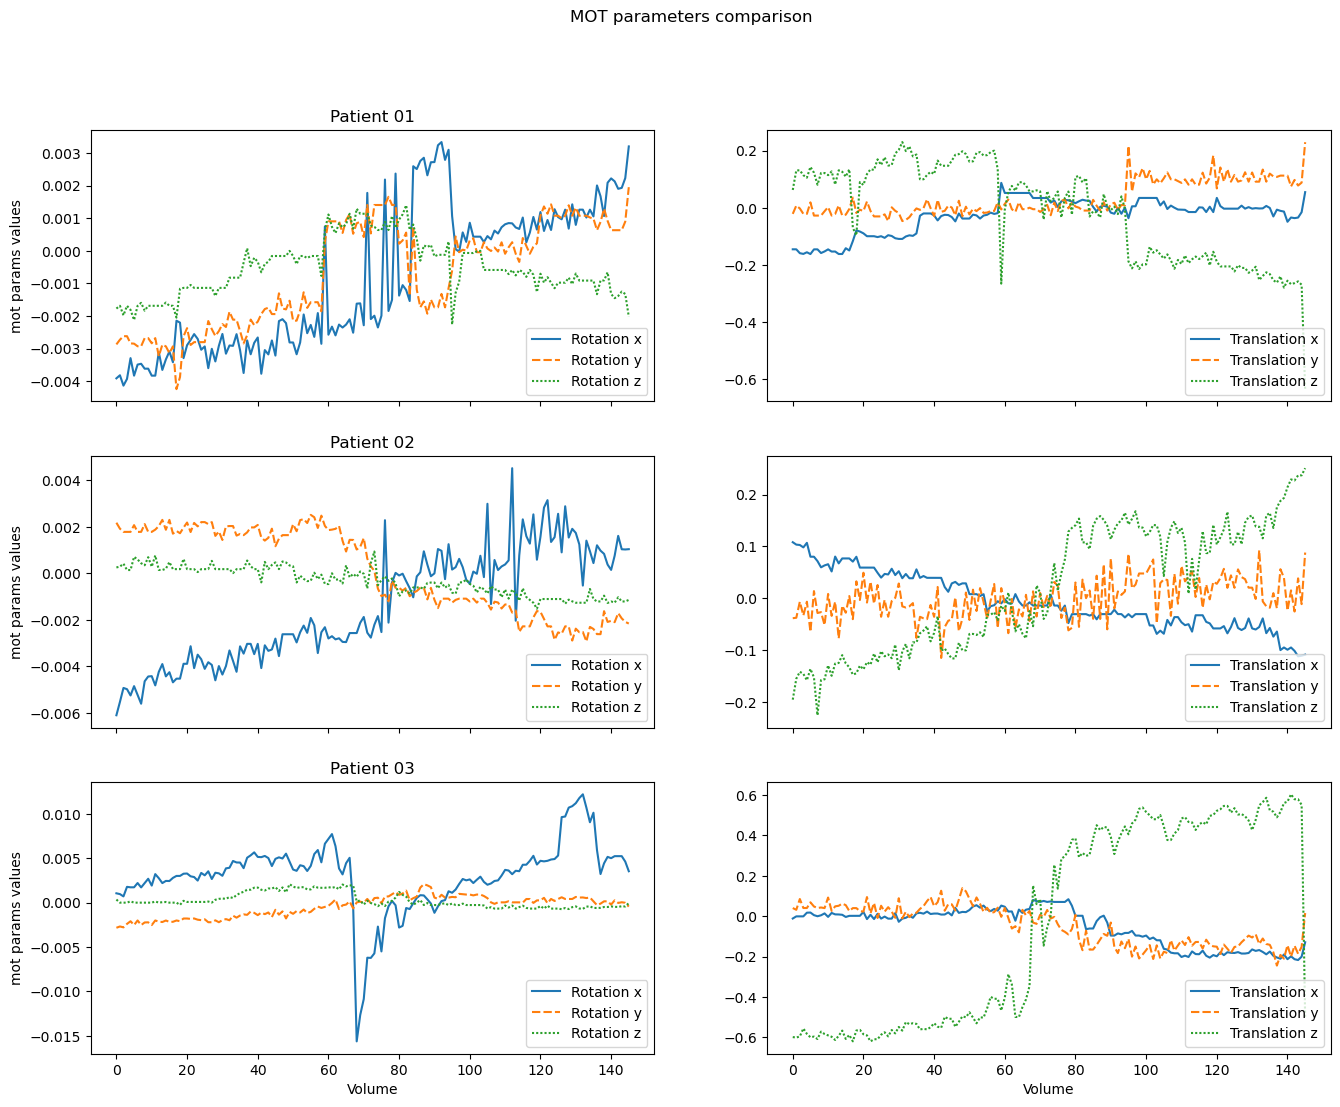

In [47]:
import seaborn as sns

num_subplots = len(list_patient)

fig, axes = plt.subplots(num_subplots, 2, figsize=(16, 4 * num_subplots), sharex=True)
fig.suptitle('MOT parameters comparison')

for i, param in enumerate(params_list):
    sns.lineplot(param[["Rotation x", "Rotation y", "Rotation z"]], ax=axes[i][0])
    sns.lineplot(param[["Translation x", "Translation y", "Translation z"]], ax=axes[i][1])
    
    axes[i][0].set_title("Patient %s" % list_patient[i])
    
    axes[i][0].set_xlabel('Volume')
    axes[i][1].set_xlabel('Volume')
    axes[i][0].set_ylabel('mot params values')
    axes[i][0].legend(loc='lower right')
    axes[i][1].legend(loc='lower right')

In [48]:
def compare_fd (fd_data_list, list_patient) :

    %matplotlib inline
    # Create subplots
    num_subplots = len(fd_data_list)

    fig, axes = plt.subplots(num_subplots, 1, figsize=(8, 4 * num_subplots), sharex=True, sharey = True)
    fig.suptitle('FD Displacement Subplots')

    for i, fd_data in enumerate(fd_data_list):
        threshold = np.quantile(fd_data,0.75) + 1.5*(np.quantile(fd_data,0.75) - np.quantile(fd_data,0.25))
        ax = axes[i]
        ax.plot(list(range(1, len(fd_data) + 1)), fd_data)
        ax.set_xlabel('Volume')
        ax.set_xlim([0, 150])
        ax.set_ylabel('FD displacement (mm)')
        ax.hlines(threshold, 0, len(fd_data), colors='black', linestyles='dashed', label='FD threshold')
        ax.set_title("patient %s" % list_patient[i])
        ax.legend()

    plt.tight_layout()
    plt.show()

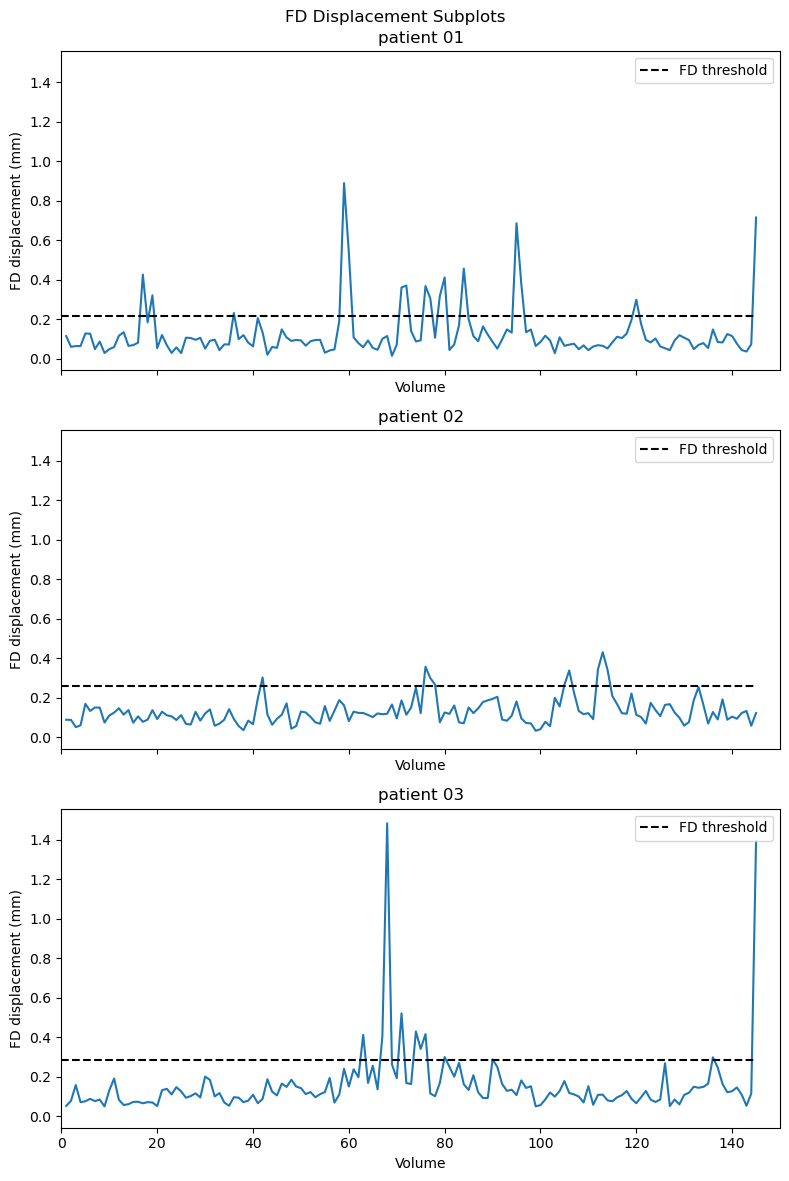

In [49]:
compare_fd (list(zip(*results))[3],list_patient)

# 4 - Outliers volumes detection

### 1) Detect the volumes with large motion with another metrics called DVARS

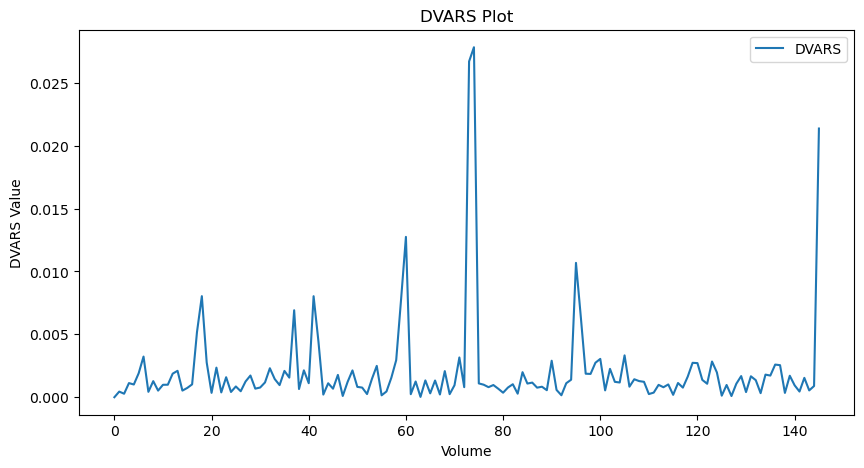

In [50]:
%matplotlib inline

import subprocess
import matplotlib.pyplot as plt

path_original_data = os.path.join(bids_root, 'sub-01', 'func', 'sub-01_task-flanker_run-1_bold.nii.gz')
output_confound_file = 'imgs/sub-01_task-flanker_run-1_bold.txt'

metric_save_file = "imgs/metric_values.txt"
plot_save_file = 'imgs/sub-01_task-flanker_metric_plot.png'

command = [
    "fsl_motion_outliers",
    "-i", path_original_data,
    "-o", output_confound_file,
]

if metric_save_file:
    command.extend(["-s", metric_save_file])

if plot_save_file:
    command.extend(["-p", plot_save_file])

subprocess.run(command, check=True)

# Load DVARS values from the text file
dvars_values = np.loadtxt(metric_save_file)

# Plot DVARS values
plt.figure(figsize=(10, 5))
plt.plot(dvars_values, label="DVARS")
plt.xlabel("Volume")
plt.ylabel("DVARS Value")
plt.title("DVARS Plot")
plt.legend()
plt.savefig(plot_save_file)
plt.show()

### 3) Define a thresold of outliers volumes : Statistical Deviation Threshold

Number of outlier volumes detected: 10
Indices of outlier volumes: [18, 37, 41, 59, 60, 73, 74, 95, 96, 145]


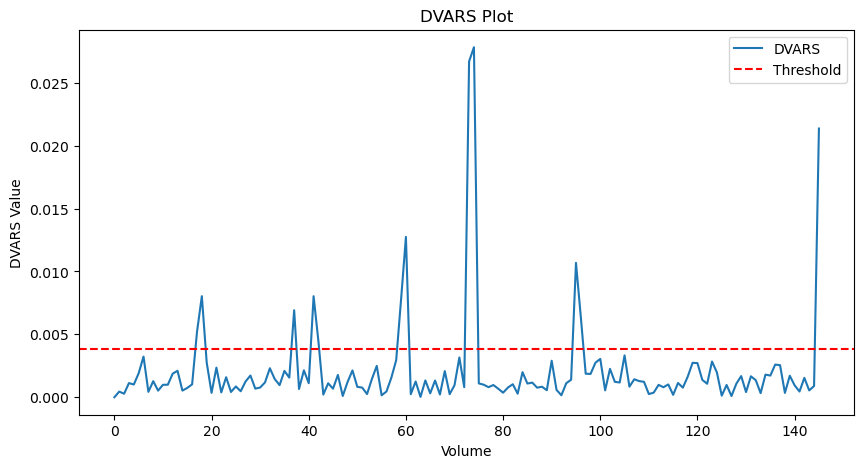

In [65]:
# Calculate mean and standard deviation of DVARS values
mean_dvars = np.mean(dvars_values)
std_dvars = np.std(dvars_values)

# Define the threshold as equal to the standard deviation 
threshold = std_dvars

# Identify outlier volumes based on the threshold
outlier_volumes = [i for i, dvars in enumerate(dvars_values) if dvars > (mean_dvars + threshold)]

print(f"Number of outlier volumes detected: {len(outlier_volumes)}")
print(f"Indices of outlier volumes: {outlier_volumes}")

# Plot DVARS values
plt.figure(figsize=(10, 5))
plt.plot(dvars_values, label="DVARS")
plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
plt.xlabel("Volume")
plt.ylabel("DVARS Value")
plt.title("DVARS Plot")
plt.legend()
plt.savefig(plot_save_file)
plt.show()